This is a notebook explaining the [Ink Detection progress prize on Kaggle](https://www.kaggle.com/competitions/vesuvius-challenge), which is part of the larger [Vesuvius Challenge](https://scrollprize.org).

For more background on the process of ink detection, be sure to check out [Tutorial 4: Ink Detection](https://scrollprize.org/tutorial4) on the Vesuvius Challenge website.

In this notebook we'll see how to train a simple ML model to detect ink in a papyrus fragment from a 3d x-ray scan of the fragment.

<img src="https://user-images.githubusercontent.com/177461/224853397-3cf86dc2-45b4-4e7c-9ec2-28a733791a75.jpg" width="200"/>

First, initialize some variables, and let's look at a photo of the fragment. We won't use this for training, but it's useful to see.

It's an infrared photo, since the ink is better visible in infrared light.

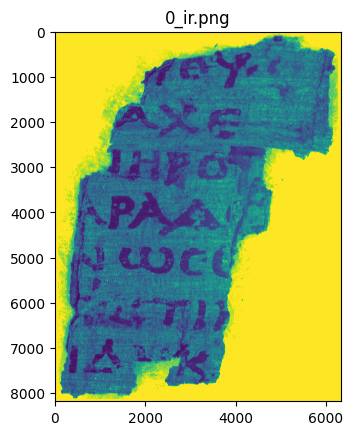

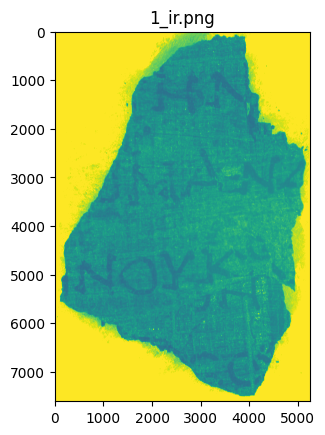

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import os
import cv2
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

PREFIX = ['data/train/1/', 'data/train/3/']
TEST_PREFIX = ['data/test/a/', 'data/test/b/']
BUFFER = 32  # Buffer size in x and y direction
Z_START = 26 # First slice in the z direction to use
Z_DIM = 6   # Number of slices in the z direction
TRAINING_STEPS = 60000
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IS_TRAIN = True
CHEPOINT = 'result/[train_loss]-0.1417-[dice_score]-0.0325-[iou_score]-0.0165-0-epoch.pkl'
FT = False # 是否加载预训练权重
THRESHOLD = 0.4 # mask阈值

for i in range(len(PREFIX)):
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_title(str(i) + "_ir.png")
    ax1.imshow(Image.open(PREFIX[i] + 'ir.png'))
    plt.show()

Let's load these binary images:
* **mask.png**: a mask of which pixels contain data, and which pixels we should ignore.
* **inklabels.png**: our label data: whether a pixel contains ink or no ink (which has been hand-labeled based on the infrared photo).

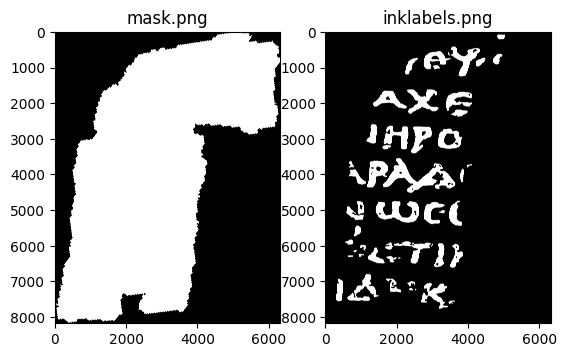

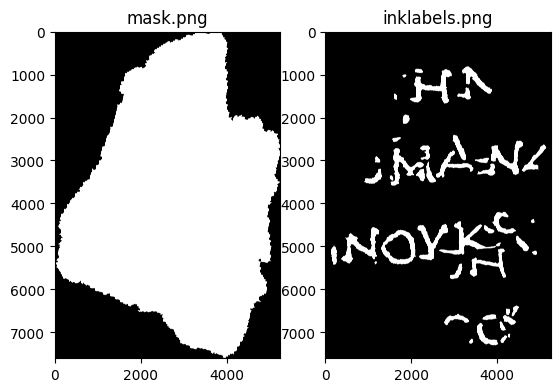

In [2]:
if IS_TRAIN:
    # 加载训练数据
    mask_list = []
    lable_list = []
    for i in range(len(PREFIX)):
        mask = np.array(Image.open(PREFIX[i]+"mask.png").convert('1'))
        label = torch.from_numpy(np.array(Image.open(PREFIX[i]+"inklabels.png"))).gt(0).float().to(DEVICE)
        mask_list.append(mask)
        lable_list.append(label)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title("mask.png")
        ax1.imshow(mask, cmap='gray')
        ax2.set_title("inklabels.png")
        ax2.imshow(label.cpu(), cmap='gray')
        plt.show()
else:
    # 加载测试数据
    shape_list = []
    test_mask_list = []
    for i in range(len(TEST_PREFIX)):
        shape_list.append(torch.from_numpy(np.array(Image.open(TEST_PREFIX[i] + "mask.png"))))
        test_mask_list.append(np.array(Image.open(TEST_PREFIX[i] + "mask.png").convert('1')))

Next, we'll load the 3d x-ray of the fragment. This is represented as a .tif image stack. The image stack is an array of 16-bit grayscale images. Each image represents a "slice" in the z-direction, going from below the papyrus, to above the papyrus. We'll convert it to a 4D tensor of 32-bit floats. We'll also convert the pixel values to the range [0, 1].

To save memory, we'll only load the innermost slices (`Z_DIM` of them). Let's look at them when we're done.

100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


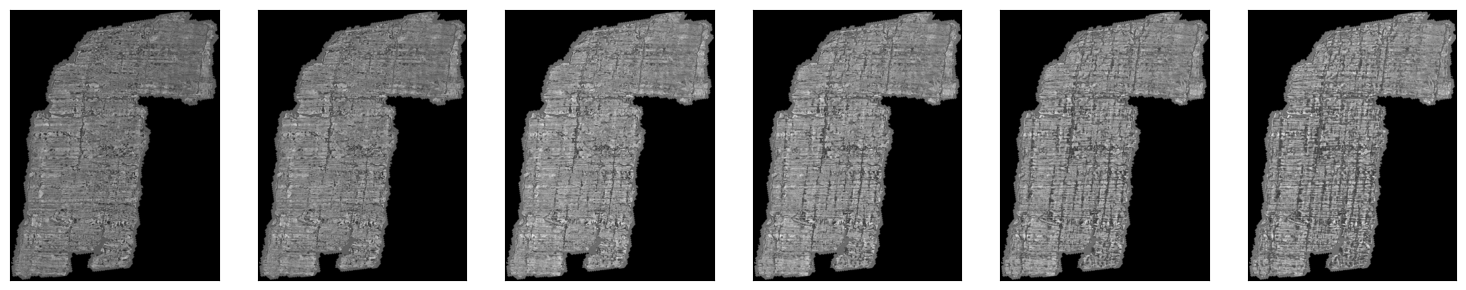

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


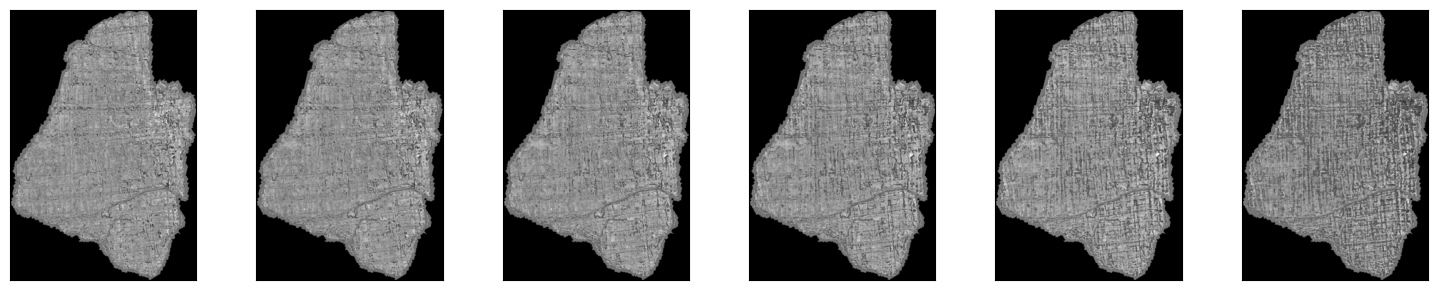

In [3]:
# Load the 3d x-ray scan, one slice at a time
if IS_TRAIN:
    # 训练数据提取，使用demo中相同的方法
    # images_list = []
    image_stack_list = []
    for i in range(len(PREFIX)):
      # images_list.append(PREFIX[i]+"surface_volume/*.tif")
      images = []
      start = Z_START
      end = Z_START + Z_DIM
      idxs = range(start, end)
      for idx in tqdm(idxs):
        image = cv2.imread(PREFIX[i] + f"surface_volume/{idx:02}.tif", 0)
        images.append(image)
      image_stack = np.stack(images, axis=2)
      # images_list.append(images)
      image_stack_list.append(image_stack)
      fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
      for image, ax in zip(images, axes):
        ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
      fig.tight_layout()
      plt.show()
      # del images
else:
    test_images_list = []
    test_image_stack_list = []
    for i in range(len(TEST_PREFIX)):
      images = [cv2.imread(filename, 0) for filename in tqdm(sorted(glob.glob(TEST_PREFIX[i]+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
      images_stack = image_stack = np.stack(images, axis=2)
      test_images_list.append(images)
      test_image_stack_list.append(images_stack)

Can you see the ink in these slices of the 3d x-ray scan..? Neither can we.

Now we'll create a dataset of subvolumes. We use a small rectangle around the letter "P" for our evaluation, and we'll exclude those pixels from the training set. (It's actually a Greek letter "rho", which looks similar to our "P".)

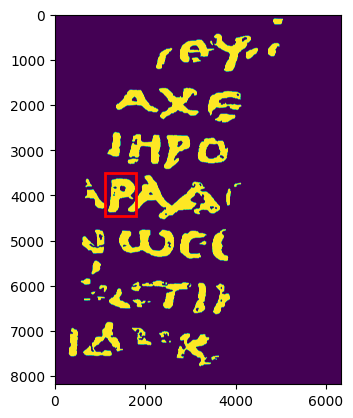

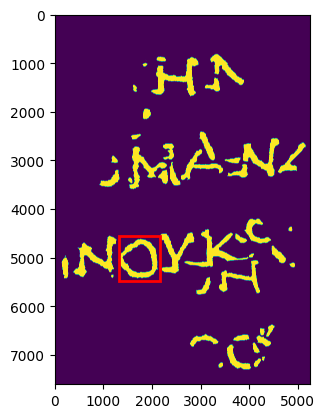

In [4]:
# rect_list = [(1100, 3500, 700, 950), 
#             (1403, 7115, 1660, 1142), 
#              (1310, 4554, 860, 930)]

rect_list = [(1100, 3500, 700, 950),
              (1310, 4554, 860, 930)]
if IS_TRAIN:
    for i in range(len(lable_list)):
        rect = rect_list[i]
        fig, ax = plt.subplots()
        ax.imshow(lable_list[i].cpu())
        patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(patch)
        plt.show()

Now we'll define a PyTorch dataset and (super simple) model.

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2    
# ============== augmentation =============
train_aug_list = [
    # A.RandomResizedCrop(
    #     size, size, scale=(0.85, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.75),
    A.ShiftScaleRotate(p=0.75),
    A.OneOf([
            A.GaussNoise(var_limit=[10, 50]),
            A.GaussianBlur(),
            A.MotionBlur(),
            ], p=0.4),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.CoarseDropout(max_holes=1, max_width=int(BUFFER * 2 * 0.3), max_height=int(BUFFER * 2  * 0.3), 
                    mask_fill_value=0, p=0.5),
    # A.Cutout(max_h_size=int(size * 0.6),
    #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
    A.Normalize(
        mean= [0] * Z_DIM,
        std= [1] * Z_DIM
    ),
    ToTensorV2(transpose_mask=True),
]

valid_aug_list = [
    A.Normalize(
        mean= [0] * Z_DIM,
        std= [1] * Z_DIM
    ),
    ToTensorV2(transpose_mask=True),
]

def get_transforms(data):
    if data == 'train':
        aug = A.Compose(train_aug_list)
    elif data == 'valid':
        aug = A.Compose(valid_aug_list)
    return aug
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels, is_train, transform):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
        self.is_train = is_train
        self.transform = transform
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER, :]
        data = self.transform(image=subvolume)
        subvolume = data['image'].unsqueeze(0)
        if self.is_train:
            inklabel = self.label[y, x].view(1)
            return subvolume, inklabel
        else:
            return subvolume
# IOU and Dice Score
def dice_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2 * inter + epsilon) / (den + epsilon)).mean()
    return dice


def iou_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true * y_pred).sum(dim=dim)
    iou = ((inter + epsilon) / (union + epsilon)).mean()
    return iou

Now we'll train the model. Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853655-3fad9edb-c798-452e-94d0-f74efe71c08e.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif"/></a>

This typically takes about 10 minutes.

In [6]:
if IS_TRAIN:
    print("Generating pixel lists of train...")
    # Split our dataset into train and val. The pixels inside the rect are the 
    # val set, and the pixels outside the rect are the train set.
    # 直接加载全部显存会爆炸, 放在train里面单独加载
    pixels_inside_rect_list = []
    pixels_outside_rect_list = []
    for i in tqdm(range(len(mask_list))):
        pixels_inside_rect = []
        pixels_outside_rect = []
        for pixel in zip(*np.where(mask_list[i] == 1)):
            if pixel[1] < BUFFER or pixel[1] >= mask_list[i].shape[1]-BUFFER-1 or pixel[0] < BUFFER or pixel[0] >= mask_list[i].shape[0]-BUFFER-1:
                continue # Too close to the edge
            if pixel[1] >= rect_list[i][0] and pixel[1] <= rect_list[i][0]+rect_list[i][2] and pixel[0] >= rect_list[i][1] and pixel[0] <= rect_list[i][1]+rect_list[i][3]:
                pixels_inside_rect.append(pixel)
            else:
                pixels_outside_rect.append(pixel)
        
        pixels_inside_rect_list.append(pixels_inside_rect)
        pixels_outside_rect_list.append(pixels_outside_rect)
    # np.savez('res.npz', pixels_inside_rect_list=np.array(pixels_inside_rect_list,
    #                                                      pixels_outside_rect_list=np.array(pixels_outside_rect_list)))

else:
    print("Generating pixel lists of test...")
    # test不需要分割，取mask内的全部
    pixels_test_rect_list = []
    for i in range(len(test_mask_list)):
        pixels_test_rect = []
        for pixel in zip(*np.where(test_mask_list[i] == 1)):
            if pixel[1] < BUFFER or pixel[1] >= test_mask_list[i].shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= test_mask_list[i].shape[0]-BUFFER:
                continue # Too close to the edge
            pixels_test_rect.append(pixel)
        pixels_test_rect_list.append(pixels_test_rect)

Generating pixel lists of train...


100%|██████████| 2/2 [00:43<00:00, 21.90s/it]


In [7]:
np.savez('/media/stu/0B3309EB0B3309EB/res.npz', pixels_inside_rect_list=np.array(pixels_inside_rect_list),
                                                         pixels_outside_rect_list=np.array(pixels_outside_rect_list))

/tmp/ipykernel_8525/2868988428.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.savez('res.npz', pixels_inside_rect_list=np.array(pixels_inside_rect_list),


KeyboardInterrupt: 

In [8]:
import inspect
import math
from typing import Union


# Automatically get the current list of classes in inkid.model https://stackoverflow.com/a/1796247
def model_choices():
    return [
        s for (s, _) in inspect.getmembers(sys.modules["inkid.model"], inspect.isclass)
    ]


def conv_output_shape(
    input_shape,
    kernel_size: Union[int, tuple],
    stride: Union[int, tuple],
    padding: Union[int, tuple],
    dilation: Union[int, tuple] = 1,
):
    dim = len(input_shape)
    # Accept either ints or tuples for these parameters. If int, then convert into tuple (same value all for all dims).
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size,) * dim
    if isinstance(stride, int):
        stride = (stride,) * dim
    if isinstance(padding, int):
        padding = (padding,) * dim
    if isinstance(dilation, int):
        dilation = (dilation,) * dim
    # https://pytorch.org/docs/stable/nn.html#torch.nn.Conv3d See "Shape:" section.
    return tuple(
        math.floor(
            (input_shape[d] + 2 * padding[d] - dilation[d] * (kernel_size[d] - 1) - 1)
            / stride[d]
            + 1
        )
        for d in range(dim)
    )
class Subvolume3DcnnEncoder(torch.nn.Module):
    def __init__(
        self, subvolume_shape, batch_norm_momentum, no_batch_norm, filters, in_channels
    ):
        super().__init__()

        input_shape = subvolume_shape

        self._batch_norm = not no_batch_norm
        self._in_channels = in_channels

        paddings = [1, 1, 1, 1]
        kernel_sizes = [3, 3, 3, 3]
        strides = [1, 2, 2, 2]

        self.conv1 = torch.nn.Conv3d(
            in_channels=in_channels,
            out_channels=filters[0],
            kernel_size=kernel_sizes[0],
            stride=strides[0],
            padding=paddings[0],
        )
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)
        self.batch_norm1 = torch.nn.BatchNorm3d(
            num_features=filters[0], momentum=batch_norm_momentum
        )
        shape = conv_output_shape(input_shape, kernel_sizes[0], strides[0], paddings[0])

        self.conv2 = torch.nn.Conv3d(
            in_channels=filters[0],
            out_channels=filters[1],
            kernel_size=kernel_sizes[1],
            stride=strides[1],
            padding=paddings[1],
        )
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)
        self.batch_norm2 = torch.nn.BatchNorm3d(
            num_features=filters[1], momentum=batch_norm_momentum
        )
        shape = conv_output_shape(shape, kernel_sizes[1], strides[1], paddings[1])

        self.conv3 = torch.nn.Conv3d(
            in_channels=filters[1],
            out_channels=filters[2],
            kernel_size=kernel_sizes[2],
            stride=strides[2],
            padding=paddings[2],
        )
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.zeros_(self.conv3.bias)
        self.batch_norm3 = torch.nn.BatchNorm3d(
            num_features=filters[2], momentum=batch_norm_momentum
        )
        shape = conv_output_shape(shape, kernel_sizes[2], strides[2], paddings[2])

        self.conv4 = torch.nn.Conv3d(
            in_channels=filters[2],
            out_channels=filters[3],
            kernel_size=kernel_sizes[3],
            stride=strides[3],
            padding=paddings[3],
        )
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.zeros_(self.conv4.bias)
        self.batch_norm4 = torch.nn.BatchNorm3d(
            num_features=filters[3], momentum=batch_norm_momentum
        )
        shape = conv_output_shape(shape, kernel_sizes[3], strides[3], paddings[3])
        self.output_shape = (filters[3],) + shape

    def forward(self, x):
        if self._in_channels > 1:
            x = torch.squeeze(x)
        y = self.conv1(x)
        y = torch.nn.functional.relu(y)
        if self._batch_norm:
            y = self.batch_norm1(y)
        y = self.conv2(y)
        y = torch.nn.functional.relu(y)
        if self._batch_norm:
            y = self.batch_norm2(y)
        y = self.conv3(y)
        y = torch.nn.functional.relu(y)
        if self._batch_norm:
            y = self.batch_norm3(y)
        y = self.conv4(y)
        y = torch.nn.functional.relu(y)
        if self._batch_norm:
            y = self.batch_norm4(y)

        return y
class LinearInkDecoder(torch.nn.Module):
    def __init__(
        self, _, input_shape, output_neurons
    ):  # Unnamed parameter is previously dropout
        super().__init__()

        self.fc = torch.nn.LazyLinear(output_neurons)

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        y = self.flatten(x)
        y = self.fc(y)
        # Add some dimensions to match the dimensionality of label which is always 2D even if shape is (1, 1)
        y = torch.unsqueeze(y, 2)
        y = torch.unsqueeze(y, 3)
        return y  # (N, C, H, W)
class DeeperLinearInkDecoder(torch.nn.Module):
    def __init__(
        self, _, input_shape, output_neurons
    ):  # Unnamed parameter is previously dropout
        super().__init__()

        hidden_layer_size = 128
        self.fc1 = torch.nn.LazyLinear(hidden_layer_size)
        self.fc2 = torch.nn.LazyLinear(hidden_layer_size)
        self.fc3 = torch.nn.LazyLinear(hidden_layer_size)
        self.fc4 = torch.nn.LazyLinear(output_neurons)

        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        y = self.flatten(x)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        y = self.fc4(y)
        # Add some dimensions to match the dimensionality of label which is always 2D even if shape is (1, 1)
        y = torch.unsqueeze(y, 2)
        y = torch.unsqueeze(y, 3)
        return y  # (N, C, H, W)


class DeeperInkClassifier3DCNN(torch.nn.Module):
    def __init__(
        self, subvolume_shape, batch_norm_momentum, no_batch_norm, filters, drop_rate
    ):
        super().__init__()
        self.encoder = Subvolume3DcnnEncoder(
            subvolume_shape, batch_norm_momentum, no_batch_norm, filters, in_channels=1
        )
        self.decoder = DeeperLinearInkDecoder(
            drop_rate, self.encoder.output_shape, output_neurons=1
        )
        self.labels = ["ink_classes"]

    def forward(self, x):
        return self.decoder(self.encoder(x)).squeeze().unsqueeze(1)
    
class Subvolume3DUNet(torch.nn.Module):
    def __init__(
        self, subvolume_shape, bn_momentum, starting_channels, in_channels, decode=True
    ):
        super().__init__()

        # Sanity check that our starting_channels is divisible by 2 since we
        # need to double and halve this parameter repeatedly
        if starting_channels % 2 != 0:
            raise ValueError("starting_channels must be divisible by 2")

        input_shape = subvolume_shape

        pool_kernel_size = 2
        pool_stride = 2
        pool_padding = 0  # Not listed in paper

        upconv_kernel_size = 2
        upconv_stride = 2
        upconv_padding = 0  # Not listed in paper

        final_conv_kernel_size = 1
        final_conv_stride = 1  # Not listed in paper, but stride 1 makes size work out
        final_conv_padding = 0  # Not listed in paper

        channels = starting_channels

        self._in_channels = in_channels
        self._encoder_modules = torch.nn.ModuleList()
        self._decoder_modules = torch.nn.ModuleList()
        self._decode = decode
        # The output shape depends on whether we run the decoder or not.
        out_channels = in_channels if decode else starting_channels * 16
        output_shape = [out_channels]
        output_shape.extend(
            input_shape if decode else map(lambda x: x / 8, input_shape)
        )
        self.output_shape = tuple(output_shape)

        # Build the left side of the "U" shape plus bottom (encoder)
        for i in range(4):
            if i > 0:
                self._encoder_modules.append(
                    torch.nn.MaxPool3d(
                        kernel_size=pool_kernel_size,
                        stride=pool_stride,
                        padding=pool_padding,
                    )
                )
            self._encoder_modules.append(
                self._ConvBlock(
                    in_channels=channels if i > 0 else in_channels,
                    out_channels=channels,
                    bn_momentum=bn_momentum,
                )
            )
            self._encoder_modules.append(
                self._ConvBlock(
                    in_channels=channels,
                    out_channels=channels * 2,
                    bn_momentum=bn_momentum,
                )
            )
            channels *= 2

        # Build the right side of the "U" shape (decoder)
        for i in range(3):
            self._decoder_modules.append(
                torch.nn.ConvTranspose3d(
                    in_channels=channels,
                    out_channels=channels,
                    kernel_size=upconv_kernel_size,
                    stride=upconv_stride,
                    padding=upconv_padding,
                )
            )
            channels //= 2
            self._decoder_modules.append(
                self._ConvBlock(
                    in_channels=channels * 3,
                    out_channels=channels,
                    bn_momentum=bn_momentum,
                )
            )

            self._decoder_modules.append(
                self._ConvBlock(
                    in_channels=channels, out_channels=channels, bn_momentum=bn_momentum
                )
            )

        # Final decoder simple convolution (decoder)
        self._decoder_modules.append(
            torch.nn.Conv3d(
                in_channels=channels,
                out_channels=out_channels,
                kernel_size=final_conv_kernel_size,
                stride=final_conv_stride,
                padding=final_conv_padding,
            )
        )

    def forward(self, x):
        if self._in_channels > 1:
            x = torch.squeeze(x)

        # 0-indexed layers where shortcut/concatenation lines should appear on
        # both the encoder and decoder sides of the network.
        encoder_shortcut_layers = (1, 4, 7)
        decoder_shortcut_layers = (0, 3, 6)

        concat_lines = []

        for i, layer in enumerate(self._encoder_modules):
            x = layer(x)
            if i in encoder_shortcut_layers:
                concat_lines.append(x)

        # If we're not supposed to run the decoder section, just return now.
        if not self._decode:
            return x

        for i, layer in enumerate(self._decoder_modules):
            x = layer(x)
            if i in decoder_shortcut_layers:
                x = torch.cat((concat_lines.pop(), x), dim=1)

        return x

    class _ConvBlock(torch.nn.Module):
        def __init__(
            self,
            in_channels,
            out_channels,
            bn_momentum,
            kernel_size=3,
            stride=1,
            padding=1,
        ):
            super().__init__()
            # Padding needs to be 1 or our subvolume will shrink by 2 in each
            # dimension upon applying the Conv3d operation
            self.conv = torch.nn.Conv3d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            )
            self.bn = torch.nn.BatchNorm3d(
                num_features=out_channels, momentum=bn_momentum
            )

        def forward(self, x):
            x = self.conv(x)
            x = self.bn(x)
            x = torch.nn.functional.relu(x)
            return x
class InkClassifier3DUNet(torch.nn.Module):
    def __init__(
        self,
        subvolume_shape_voxels,
        batch_norm_momentum,
        unet_starting_channels,
        in_channels,
        drop_rate,
    ):
        super().__init__()
        self.encoder = Subvolume3DUNet(
            subvolume_shape_voxels,
            batch_norm_momentum,
            unet_starting_channels,
            in_channels,
            decode=True,
        )
        self.decoder = LinearInkDecoder(
            drop_rate, self.encoder.output_shape, output_neurons=1
        )

    def forward(self, x):
        return self.decoder(self.encoder(x)).squeeze().unsqueeze(1)

In [9]:
model = DeeperInkClassifier3DCNN(subvolume_shape=(BATCH_SIZE, 1, Z_DIM, 64, 64), batch_norm_momentum=0.1, no_batch_norm=False, filters=[8, 16, 16, 32], drop_rate=0.1).to(DEVICE)
model_name = 'inkid'
if FT:
    try:
        checkpoint = torch.load(CHEPOINT, map_location=DEVICE)
        models_dict = model.state_dict()
        for model_part in models_dict:
            if model_part in checkpoint:
                models_dict[model_part] = checkpoint[model_part]
        model.load_state_dict(models_dict)
        print('Checkpoint loaded')
    except:
        print('Checkpoint not loaded')
        pass

/home/stu/anaconda3/envs/dtt/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
if IS_TRAIN:
    # 实例化SummaryWriter对象
    torch.cuda.empty_cache()
    writer = SummaryWriter('result/logs')
    EPOCH = 30
    T_max = TRAINING_STEPS * 2
    min_lr = 0.000001
    print('''
    Starting training:
        Model: {}
        Epochs: {}
        Batch size: {}
        Learning rate: {}
        Training Step: {}
        CUDA: {}
    '''.format(model_name,
               EPOCH,
               BATCH_SIZE,
               LEARNING_RATE,
               TRAINING_STEPS,
               DEVICE.type))
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(),
                            lr=LEARNING_RATE,
                            betas=(0.9, 0.999),
                            weight_decay=0.001
                            )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=min_lr)
    max_memory = torch.cuda.max_memory_allocated(device=DEVICE) / 1E9 if torch.cuda.is_available() else 0
    # epoch_bar = tqdm(range(EPOCH), total=EPOCH)
    for epoch in range(EPOCH):
        train_dataset_list = []
        eval_dataset_list = []
        # 循环训练 1~3中的数据，每轮数据只抽取了TRAINING_STEPS的长度，也可以全部加入
        for index in range(len(image_stack_list)):
            # 加载数据
            train_dataset_list.append(SubvolumeDataset( image_stack_list[index], lable_list[index], pixels_outside_rect_list[index], IS_TRAIN, get_transforms(data='train')))
            eval_dataset_list.append(SubvolumeDataset( image_stack_list[index], lable_list[index], pixels_inside_rect_list[index], IS_TRAIN, get_transforms(data='valid')))
        train_dataset = ConcatDataset(train_dataset_list)
        train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        epoch_loss = 0
        model.train()
        # TRAINING_STEPS = len(train_loader)
        bar = tqdm(enumerate(train_loader), total=TRAINING_STEPS) 
        for i, (subvolumes, inklabels) in bar:
            if i >= TRAINING_STEPS:
                break
            optimizer.zero_grad()
            outputs = model(subvolumes.to(DEVICE))
            loss = criterion(outputs, inklabels.to(DEVICE))
            loss.backward()
            optimizer.step()
            scheduler.step()
            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
            bar.set_postfix(loss=f'{loss.item():0.4f}', epoch=epoch, gpu_mem=f'{mem:0.2f} GB')
            epoch_loss += loss.item()
        writer.add_scalar('Train/Loss', epoch_loss / TRAINING_STEPS, epoch)
        model.eval()
        dice_scores = []
        iou_socres = []
        for index in range(len(eval_dataset_list)):
            output = torch.zeros_like(lable_list[index]).float()
            true = torch.zeros_like(lable_list[index]).float()
            eval_loader = data.DataLoader(eval_dataset_list[index], batch_size=BATCH_SIZE, shuffle=False)
            with torch.no_grad():
                for i, (subvolumes, inklabels) in enumerate(tqdm(eval_loader)):
                    outputs = model(subvolumes.to(DEVICE))
                    for j, (value, true_value) in enumerate(zip(outputs, inklabels)):
                        output[pixels_inside_rect_list[index][i*BATCH_SIZE+j]] = torch.sigmoid(value)
                        true[pixels_inside_rect_list[index][i*BATCH_SIZE+j]] = true_value

                # 计算准确率
                dice_score = dice_coef(true.to(DEVICE), output.to(DEVICE), thr=THRESHOLD).item()
                iou_socre = iou_coef(true.to(DEVICE), output.to(DEVICE), thr=THRESHOLD).item()

                dice_scores.append(dice_score)
                iou_socres.append(iou_socre)
                        
                # 使用make_grid将图片转换成网格形式
                pred_mask = make_grid(output.to(DEVICE), normalize=True)
                true_mask = make_grid(true.to(DEVICE), normalize=True)
                # 使用add_image方法将图片添加到TensorBoard中
                writer.add_image('Valid/' + str(index) + 'True_mask', true_mask, global_step=epoch, dataformats="CHW")
                writer.add_image('Valid/' + str(index) + 'Pred_mask', pred_mask, global_step=epoch, dataformats="CHW")

                # fig, (ax1, ax2) = plt.subplots(1, 2)
                # ax1.imshow(output.cpu(), cmap='gray')
                # ax2.imshow(label.cpu(), cmap='gray')
                # plt.show()
        writer.add_scalar('Val/IOU', sum(iou_socres) / len(iou_socres),  epoch)
        writer.add_scalar('Val/Dice',  sum(dice_scores) / len(dice_scores),  epoch)
        import gc
        gc.collect()
        torch.cuda.empty_cache()
        torch.save(model.state_dict(), 'result/' +  '{}-DIM-{}-[train_loss]-{:.2f}-[dice_score]-{:.2f}-[iou_score]-{:.2f}-'.format(model_name, Z_DIM ,epoch_loss / TRAINING_STEPS, sum(dice_scores) / len(dice_scores), sum(iou_socres) / len(iou_socres)) + str(epoch) + '-epoch.pkl')
    writer.close()


    Starting training:
        Model: inkid
        Epochs: 30
        Batch size: 32
        Learning rate: 0.001
        Training Step: 60000
        CUDA: cuda
    


 54%|█████▍    | 11220/20833 [01:01<00:52, 182.99it/s]


KeyboardInterrupt: 

Finally, we'll generate a prediction image. We'll use the model to predict the presence of ink for each pixel in our rectangle (the val set). Conceptually it looks like this:

<a href="https://user-images.githubusercontent.com/22727759/224853653-7cffd0a4-c6fa-49a2-93c1-e3c820863a51.mp4"><img src="https://user-images.githubusercontent.com/22727759/224853379-09ae991e-02be-4ecc-a652-313165b3005c.gif"/></a>


This should take about a minute.

Remember that the model has never seen the label data within the rectangle before!

We'll plot it side-by-side with the label image. Are you able to recognize the letter "P" in it?

In [ ]:
if not IS_TRAIN:
    output_list = []
    for index in range(len(test_image_stack_list)):
        test_dataset = SubvolumeDataset(test_image_stack_list[index], None, pixels_test_rect_list[index], IS_TRAIN)
        test_eval_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        output = torch.zeros_like(shape_list[index]).float()
        model.eval()
        with torch.no_grad():
            for i, (subvolumes) in enumerate(tqdm(test_eval_loader)):
                for j, value in enumerate(model(subvolumes.to(DEVICE))):
                    output[pixels_test_rect_list[index][i*BATCH_SIZE+j]] = value
            output_list.append(output)
            out = output_list[index].gt(THRESHOLD).cpu().float().numpy()
            import cv2
            cv2.imwrite(str(index + 1) + '.png', out * 255)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(output_list[0].gt(THRESHOLD).cpu(), cmap='gray')
    ax1.imshow(output_list[1].gt(THRESHOLD).cpu(), cmap='gray')
    plt.show()
    

Since our output has to be binary, we have to choose a threshold, say 40% confidence.

In [ ]:
if IS_TRAIN:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
    ax2.imshow(label.cpu(), cmap='gray')
    plt.show()

Finally, Kaggle expects a runlength-encoded submission.csv file, so let's output that.

In [ ]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))
# rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
# print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))

Hurray! We've detected ink! Now, can you do better? :-) For example, you could start with this [example submission](https://www.kaggle.com/code/danielhavir/vesuvius-challenge-example-submission).

In [ ]:
rle_list = []
for output in outputs:
    rle_sample = rle(output)
    rle_list.append(rle_sample)
print("Id,Predicted\na," + rle_list[0] + "\nb," + rle_list[1], file=open('submission.csv', 'w'))